<a href="https://colab.research.google.com/github/negarkamali/OOS/blob/main/Intent_classification_conforml_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import re  # Import the regular expression module
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import tensorflow_hub as hub
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_oos_plus.json"
response = requests.get(url)

if response.status_code == 200:
    # Save the file content to a file in the current working directory
    with open("data_oos_plus.json", "w") as file:
        file.write(response.text)
    print("File downloaded successfully!")
else:
    print("Failed to download the file. Status code:", response.status_code)

File downloaded successfully!


In [2]:
url = "https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_oos_plus.json"
response = requests.get(url)

if response.status_code == 200:
    # Convert the file content to JSON
    data = json.loads(response.text)

    # Define a function to clean text
    def clean_text(text):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove non-alphanumeric characters
        tokens = text.split()  # Simple tokenization (splitting by spaces)
        return ' '.join(tokens)

    # Clean the data
    cleaned_data = {}
    for key, value in data.items():
        cleaned_data[key] = [(clean_text(item[0]), item[1]) for item in value]

    # Save the cleaned data to a JSON file
    with open('cleaned_data.json', 'w') as f:
        json.dump(cleaned_data, f, indent=4)

    print("Data cleaned and saved to 'cleaned_data.json'")
else:
    print("Failed to download the file. Status code:", response.status_code)


Data cleaned and saved to 'cleaned_data.json'


In [3]:
# Ensure that you have the punkt tokenizer models downloaded
nltk.download('punkt')

def tokenize_sentence(sentence):
    return word_tokenize(sentence)

def tokenize_data(input_path, output_path=None):
    # Load the data
    with open(input_path, 'r') as f:
        data = json.load(f)

    # Tokenize the data
    tokenized_data = {}
    for key, values in data.items():
        tokenized_data[key] = [[tokenize_sentence(sentence), label] for sentence, label in values]

    # Save the tokenized data (optional)
    if output_path:
        with open(output_path, 'w') as f:
            json.dump(tokenized_data, f, indent=4)

    return tokenized_data

# Input and output file paths
input_path = 'cleaned_data.json'
output_path = 'tokenized_data.json'

# Tokenize and save the data
tokenized_data = tokenize_data(input_path, output_path)


[nltk_data] Downloading package punkt to /Users/tuv5056/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Load Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def embed_sentences(sentences):
    return embed(sentences)

def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def preprocess_and_save(data, output_file):
    for key in data:
        sentences = [item[0] for item in data[key]]
        embeddings = embed_sentences(sentences)
        for i, item in enumerate(data[key]):
            item[0] = embeddings[i].numpy().tolist()  # Convert embedding to list
    with open(output_file, 'w') as f:
        json.dump(data, f)

if __name__ == "__main__":
    input_file = 'cleaned_data.json'
    output_file = 'data_oos_plus_embedded.json'
    data = load_data(input_file)
    preprocess_and_save(data, output_file)

In [5]:
# Define file path
file_path = 'data_oos_plus_embedded.json'

# Load data from JSON file
with open(file_path, 'r') as f:
    data = json.load(f)

# Separate features (X) and labels (y) for in-scope and out-of-scope data
X_train_is, y_train_is = zip(*[(embedding, label) for embedding, label in data["train"]])
X_val_is, y_val_is = zip(*[(embedding, label) for embedding, label in data["val"]])
X_test_is, y_test_is = zip(*[(embedding, label) for embedding, label in data["test"]])

X_train_oos, y_train_oos = zip(*[(embedding, 'oos') for embedding, label in data["oos_train"]])
X_val_oos, y_val_oos = zip(*[(embedding, 'oos') for embedding, label in data["oos_val"]])
X_test_oos, y_test_oos = zip(*[(embedding, 'oos') for embedding, label in data["oos_test"]])

# Convert lists to numpy arrays
X_train_is = np.array(X_train_is)
X_val_is = np.array(X_val_is)
X_test_is = np.array(X_test_is)

X_train_oos = np.array(X_train_oos)
X_val_oos = np.array(X_val_oos)
X_test_oos = np.array(X_test_oos)

print("X_train_is shape:", (X_train_is).shape)
print("X_train_oos shape:", (X_train_oos).shape)
# Combine in-scope and out-of-scope data
X_train_combined = np.vstack([X_train_is, X_train_oos])
X_val_combined = np.vstack([X_val_is, X_val_oos])
X_test_combined = np.vstack([X_test_is, X_test_oos])

label_encoder = LabelEncoder()

y_train_combined_temp = y_train_is + y_train_oos

# Fit the encoder on the training data
label_encoder.fit(y_train_combined_temp)

# Transform the labels in the training, validation, and test sets
y_train_is = label_encoder.transform(y_train_is).tolist()
y_val_is = label_encoder.transform(y_val_is).tolist()
y_test_is = label_encoder.transform(y_test_is).tolist()

y_train_oos = label_encoder.transform(y_train_oos).tolist()
y_val_oos = label_encoder.transform(y_val_oos).tolist()
y_test_oos = label_encoder.transform(y_test_oos).tolist()

print("X_train_combined shape:", (X_train_combined).shape)
y_train_combined = y_train_is + y_train_oos
y_val_combined = y_val_is + y_val_oos
y_test_combined = y_test_is + y_test_oos
print("y_test_combined:", (y_test_combined))

# Convert labels to integers using LabelEncoder, fitting on the combined label set
# label_encoder = LabelEncoder()
# y_train_combined = label_encoder.fit_transform(y_train_combined)
# y_val_combined = label_encoder.transform(y_val_combined)
# y_test_combined = label_encoder.transform(y_test_combined)

# # Convert integer labels to one-hot encoding
# y_train_combined = to_categorical(y_train_combined)
# y_val_combined = to_categorical(y_val_combined)
# y_test_combined = to_categorical(y_test_combined)





X_train_is shape: (15000, 512)
X_train_oos shape: (250, 512)
X_train_combined shape: (15250, 512)
y_test_combined: [132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41

everything from here on is including the out-of-distribution data (combined)

In [6]:
# from sklearn.model_selection import train_test_split
# # Load preprocessed data
# (X_train, y_train), (X_val, y_val), (X_test, y_test), label_encoder = load_and_preprocess_data()
# # Convert y_test from one-hot encoding to label encoding for stratification
# y_test_labels = np.argmax(y_test, axis=1)

# # Split test set into calibration and final test set (50-50 split)
# X_cal, X_test_final, y_cal, y_test_final = train_test_split(
#     X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
# )


In [9]:
# Define and compile the model
# model_MLP = Sequential([
#     Dense(200, input_shape=(X_train.shape[1],), activation='tanh'),
#     Dropout(0.5),
#     Dense(200, activation='tanh'),
#     Dropout(0.5),
#     Dense(y_train.shape[1], activation='softmax')
# ])

# Number of unique classes
num_classes = len(np.unique(y_train_combined))

# Define the MLP model
model_MLP = MLPClassifier(
    hidden_layer_sizes=(200, 200), # Two hidden layers each with 200 units
    activation='tanh',
    solver='adam',                # Optimizer
    alpha=0,                      # Regularization (L2 penalty), set to 0 for now
    batch_size='auto',            # Auto batch size
    learning_rate='constant',     # Learning rate schedule
    max_iter=200,                 # Maximum number of iterations
    shuffle=True,                 # Shuffle data for each epoch
    random_state=42,              # Random seed for reproducibility
    verbose=True,                  # Print out progress
)


model_MLP.fit(X_train_combined, y_train_combined)


Iteration 1, loss = 3.96773394
Iteration 2, loss = 1.17215025
Iteration 3, loss = 0.47850516
Iteration 4, loss = 0.31205548
Iteration 5, loss = 0.23570650
Iteration 6, loss = 0.18818021
Iteration 7, loss = 0.15674429
Iteration 8, loss = 0.13202468
Iteration 9, loss = 0.11155655
Iteration 10, loss = 0.09677795
Iteration 11, loss = 0.08315279
Iteration 12, loss = 0.07269317
Iteration 13, loss = 0.06404950
Iteration 14, loss = 0.05624684
Iteration 15, loss = 0.04947828
Iteration 16, loss = 0.04409805
Iteration 17, loss = 0.03923931
Iteration 18, loss = 0.03510974
Iteration 19, loss = 0.03086062
Iteration 20, loss = 0.02813885
Iteration 21, loss = 0.02553045
Iteration 22, loss = 0.02280518
Iteration 23, loss = 0.02073667
Iteration 24, loss = 0.01894732
Iteration 25, loss = 0.01701186
Iteration 26, loss = 0.01623894
Iteration 27, loss = 0.01420287
Iteration 28, loss = 0.01300334
Iteration 29, loss = 0.01189060
Iteration 30, loss = 0.01101830
Iteration 31, loss = 0.01007789
Iteration 32, los

MLPClassifier(activation='tanh', alpha=0, hidden_layer_sizes=(200, 200),
              random_state=42, verbose=True)

In [10]:
# model_MLP.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
X_val_combined.shape

(3100, 512)

In [12]:
X_train_combined.shape

(15250, 512)

In [13]:
X_test_combined.shape

(5500, 512)

In [14]:
# Evaluate the model on the test data
#test acuuracy - classification repport
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import accuracy_score, recall_score
y_pred_is = model_MLP.predict(X_test_is)
# Calculate accuracy
accuracy_is = accuracy_score(y_test_is, y_pred_is)
print("In-distribution Test Accuracy:", accuracy_is)


y_pred_oos = model_MLP.predict(X_test_oos)
# Calculate accuracy
accuracy_oos = accuracy_score(y_test_oos, y_pred_oos)
print("Out-of-distribution Test Accuracy:", accuracy_oos)


y_pred_full = model_MLP.predict(X_test_combined)
# Calculate accuracy
accuracy_full = accuracy_score(y_test_combined, y_pred_full)
print("Full Data Test Accuracy:", accuracy_full)

# Calculate recall for out-of-scope class
recall_oos = recall_score(y_test_oos, y_pred_oos, average='weighted')
print("Out-of-distribution Recall:", recall_oos)
print(y_test_oos[1:10],y_pred_oos[1:10])

In-distribution Test Accuracy: 0.9353333333333333
Out-of-distribution Test Accuracy: 0.506
Full Data Test Accuracy: 0.8572727272727273
Out-of-distribution Recall: 0.506
[80, 80, 80, 80, 80, 80, 80, 80, 80] [ 80  80 114  80  81  56  72  52  80]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:

# # Identify the 'oos' class index
# oos_class_index = label_encoder.transform(['oos'])[0]

# # Predictions for out-of-scope data
# oos_predictions = model_MLP.predict(X_test_final[y_test_final[:, oos_class_index] == 1])
# oos_predictions_labels = np.argmax(oos_predictions, axis=-1)

# # True labels for out-of-scope data
# y_test_oos_true_labels = np.full(oos_predictions_labels.shape, oos_class_index)

# # Calculate recall for out-of-scope data
# oos_recall = recall_score(y_test_oos_true_labels, oos_predictions_labels, average='micro')
# print("Out-of-scope Recall:", oos_recall)


conformal prediction

In [16]:
#  #Convert the target values from one-hot encoding to label encoding

# y_train_labels = np.argmax(y_train, axis=1)
# y_cal_labels = np.argmax(y_val, axis=1)


# from sklearn.neural_network import MLPClassifier
# # # Initialize and train the MLP classifier
# clf = MLPClassifier(random_state=42).fit(X_train, y_train_labels)

# y_pred_proba = clf.predict_proba(X_test)

In [17]:
# y_val_labels = np.argmax(y_val, axis=1) #to use in calibration set
# y_test_labels = np.argmax(y_test, axis=1)

In [18]:
#!pip install mapie

In [19]:

# y_test_oos
# # Convert labels to integers using LabelEncoder, fitting on the combined label set
# label_encoder = LabelEncoder()
# y_train_oos = label_encoder.fit_transform(y_train_oos)
# y_val_oos = label_encoder.transform(y_val_oos)
# y_test_oos = label_encoder.transform(y_test_oos)

# # # Convert integer labels to one-hot encoding
# y_train_oos = to_categorical(y_train_oos)
# y_val_oos = to_categorical(y_val_oos)
# y_test_oos = to_categorical(y_test_oos)


# y_val_oos_labels = np.argmax(y_val_oos, axis=1)

In [20]:
# # X_train, y_train = zip(*[(embedding, label) for embedding, label in data["train"]])
# # X_val, y_val = zip(*[(embedding, label) for embedding, label in data["val"]])
# X_test, y_test = zip(*[(embedding, label) for embedding, label in data["test"]])
# print(y_test)
# # X_train = np.array(X_train)
# #X_val = np.array(X_val)
# X_test = np.array(X_test)


# # Convert labels to integers using LabelEncoder, fitting on the combined label set
# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(y_train)
# # y_val = label_encoder.transform(y_val)
# y_test = label_encoder.transform(y_test)

# # # Convert integer labels to one-hot encoding
# # y_train = to_categorical(y_train)
# # y_val = to_categorical(y_val)
# y_test = to_categorical(y_test)


In [21]:
# probabilities = clf.predict_proba(X_cal)
# assert np.allclose(probabilities.sum(axis=1), 1), "Probabilities do not sum up to 1"


In [22]:
# from sklearn.preprocessing import LabelEncoder

# # Instantiate the encoder
# label_encoder = LabelEncoder()

# # Fit and transform y_test to get integer labels

# y_test_combined_int = label_encoder.fit_transform(y_test_combined)
# y_test_is_int = label_encoder.fit_transform(y_test_is)
# y_test_oos_int = label_encoder.fit_transform(y_test_oos)

# print(y_test_oos_int)

In [23]:
#y_test_combined_int.shape

In [24]:

# Initialize MAPIE
from mapie.classification import MapieClassifier

mapie_score = MapieClassifier(estimator=model_MLP, cv="prefit", method="aps", random_state=42)
mapie_score.fit(X_val_combined, y_val_combined)

from mapie.metrics import classification_coverage_score,classification_mean_width_score, cumulative_differences
alpha = 0.05
y_pred_scoreComb, y_ps_scoreComb = mapie_score.predict(X_test_combined, alpha=alpha)
y_ps_scoreComb = np.squeeze(y_ps_scoreComb)
covComb = classification_coverage_score(y_test_combined, y_ps_scoreComb)
setsizeComb = classification_mean_width_score(y_ps_scoreComb)
print("Coverage for Full Data:",covComb)
print("Average Set Size for Full Data:",setsizeComb)

Coverage for Full Data: 0.928
Average Set Size for Full Data: 1.7658181818181817


In [25]:
#mapie_score.fit(X_val_is, y_val_is)
y_pred_scoreIn, y_ps_scoreIn = mapie_score.predict(X_test_is, alpha=alpha)
y_ps_scoreIn = np.squeeze(y_ps_scoreIn)

covIn = classification_coverage_score(y_test_is, y_ps_scoreIn)
setsizeIn = classification_mean_width_score(y_ps_scoreIn)
print("Coverage for In-Distribution Data:",covIn)
print("Average Set Size for In-Distribution  Data:",setsizeIn)

Coverage for In-Distribution Data: 0.978
Average Set Size for In-Distribution  Data: 1.3037777777777777


In [26]:

y_pred_scoreOOD, y_ps_scoreOOD = mapie_score.predict(X_test_oos, alpha=alpha)
y_ps_scoreOOD = np.squeeze(y_ps_scoreOOD)

covOOD = classification_coverage_score(y_test_oos, y_ps_scoreOOD)
setsizeOOD = classification_mean_width_score(y_ps_scoreOOD)
print("Coverage for Out-Of-Distribution Data:",covOOD)
print("Average Set Size for Out-Of-Distribution  Data:",setsizeOOD)

Coverage for Out-Of-Distribution Data: 0.703
Average Set Size for Out-Of-Distribution  Data: 3.845


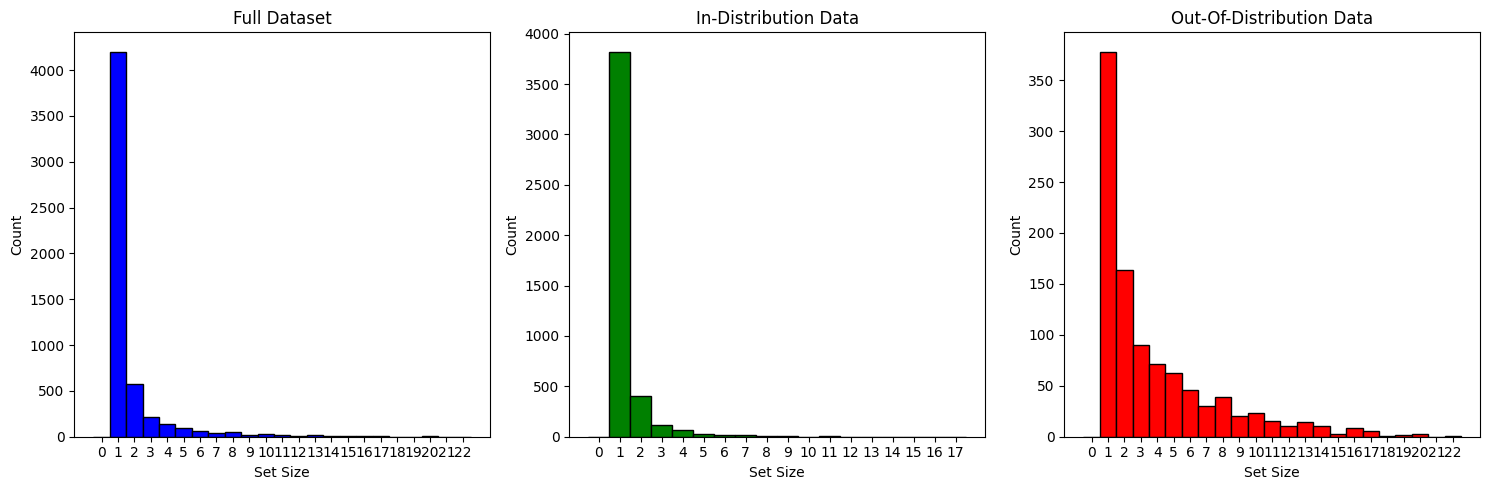

In [27]:
# Count the number of True values for each set
true_counts_full = np.sum(y_ps_scoreComb, axis=1)
true_counts_in = np.sum(y_ps_scoreIn, axis=1)
true_counts_out = np.sum(y_ps_scoreOOD, axis=1)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns for side by side histograms

# Histogram for the full dataset
axs[0].hist(true_counts_full, bins=range(int(max(true_counts_full)) + 2), edgecolor='black', align='left', color='blue')
axs[0].set_title('Full Dataset')
axs[0].set_xlabel('Set Size')
axs[0].set_ylabel('Count')
axs[0].set_xticks(range(int(max(true_counts_full)) + 1))

# Histogram for the in-distribution data
axs[1].hist(true_counts_in, bins=range(int(max(true_counts_in)) + 2), edgecolor='black', align='left', color='green')
axs[1].set_title('In-Distribution Data')
axs[1].set_xlabel('Set Size')
axs[1].set_ylabel('Count')
axs[1].set_xticks(range(int(max(true_counts_in)) + 1))

# Histogram for the out-of-distribution data
axs[2].hist(true_counts_out, bins=range(int(max(true_counts_out)) + 2), edgecolor='black', align='left', color='red')
axs[2].set_title('Out-Of-Distribution Data')
axs[2].set_xlabel('Set Size')
axs[2].set_ylabel('Count')
axs[2].set_xticks(range(int(max(true_counts_out)) + 1))

plt.tight_layout()
plt.show()

In [28]:

results = pd.DataFrame(list(map(np.ravel, y_ps_score)))
results['prediction'] = y_pred_score

y_test_labels = np.argmax(y_test_final, axis=1)
results['label'] = y_test_labels

NameError: name 'y_ps_score' is not defined

In [ ]:
results

In [ ]:
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed
    # display.float_format = lambda x: '{:,.2f}'.format(x)  # set as needed
set_pandas_display_options()

In [ ]:
filtered_results = results.loc[results['prediction'] != results['label']]
print("Shape of filtered_results:", filtered_results.shape)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the true count
results['true_count'] = results.iloc[:, :-2].apply(lambda row: sum(row == True), axis=1)

# Plotting with different strategies
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 10))

# Regular Histogram
axes[0].hist(results['true_count'], bins=30, edgecolor='black')
axes[0].set_title('Set Size Regular Histogram')
axes[0].set_xlabel('Count of True Values')
axes[0].set_ylabel('Frequency')

# Log Scale
axes[1].hist(results['true_count'], bins=30, edgecolor='black', log=True)
axes[1].set_title('Set Size Histogram with Log Scale')
axes[1].set_xlabel('Count of True Values')
axes[1].set_ylabel('Log(Frequency)')


plt.tight_layout()
plt.show()


cross entropy calculations

In [ ]:
import json
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 1. Load and preprocess the data
def load_and_preprocess_data():
    # Define file path
    file_path = 'data_oos_plus_embedded.json'

    # Load data from JSON file
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Separate features (X) and labels (y) for in-scope data

    X_train, y_train = zip(*[(embedding, label) for embedding, label in data["train"]])
    X_val, y_val = zip(*[(embedding, label) for embedding, label in data["val"]])
    X_test, y_test = zip(*[(embedding, label) for embedding, label in data["test"]])

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)

    # Convert labels to integers using LabelEncoder
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)

    return X_train, y_train_encoded, X_val, y_val_encoded, X_test, y_test_encoded, label_encoder

# 2. Load data
X_train, y_train_encoded, X_val, y_val_encoded, X_test, y_test_encoded, label_encoder = load_and_preprocess_data()

In [ ]:
y_train_encoded

In [ ]:
# 3. Train a new MLP model on this in-distribution data
model = Sequential([
    Dense(200, input_shape=(X_train.shape[1],), activation='tanh'),
    Dropout(0.5),
    Dense(200, activation='tanh'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
    ]) # Number of classes as output nodes


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# One-hot encode the labels
y_train_onehot = to_categorical(y_train_encoded)
y_val_onehot = to_categorical(y_val_encoded)
y_train_onehot

In [ ]:
print(np.unique(y_train_onehot))

In [ ]:
print(np.unique(y_train))

In [ ]:
model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot), epochs=50, batch_size=16)

# 4. Make predictions using this model
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# 5. Convert true labels and predicted labels to one-hot encoded representations
y_test_onehot = to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))
y_pred_onehot = to_categorical(y_pred_labels, num_classes=len(label_encoder.classes_))

# 6. Compute cross-entropy
cross_entropy = -np.sum(y_test_onehot * np.log(y_pred_probs)) / y_test_onehot.shape[0]
print("Cross-Entropy:", cross_entropy)

In [ ]:
# y_true is  one-hot encoded ground truth and y_pred is the softmax output of model - ONLY for in-distribution


In [ ]:
cross_entropy_losses = -np.sum(y_true * np.log(y_pred + 1e-10), axis=1)  # Added a small value to avoid log(0)

# Plot the distribution
plt.hist(cross_entropy_losses, bins=50, edgecolor='black')
plt.title('Distribution of Cross-Entropy Losses for Intent Classification')
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Frequency')
plt.show()

# Determine the threshold for categorizing difficulty
median_loss = np.median(cross_entropy_losses)
print(f"Median Cross-Entropy Loss: {median_loss}")

# Categorize samples based on the threshold
easy_samples = np.where(cross_entropy_losses <= median_loss)
hard_samples = np.where(cross_entropy_losses > median_loss)
